# CPD using TIRE

In [2]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Lambda, Input, Dense
# from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences


import utils
import TIRE
from importlib import reload 

# experiments 
# import experiments.replication as x
# import experiments.each_dimensions as x
# import experiments.each_dimensions_ICA as x
import experiments.Original as x


## Set parameters

In [2]:
# ipynb, mỗi lần đổi code, phải restart kernal để load lại toàn bộ. Import thì chỉ lấy từ cache, ko lấy được code mới. Lý do

In [2]:
workflow = x.Original_Experiment()
workflow.set_hyperparameter_type('alpha')
workflow.hyperparams.experiment_name

'eeg_dmd'

## Generate data

In [3]:
# training
series = 1
print('training')
training_timeseries, training_timeseries_len, training_windows_TD, training_windows_FD = workflow.get_timeseries(f'../data/eeg_grasp_and_lift/dataset{series}_training_data.csv')
print('call breakpoint')
training_breakpoints = workflow.get_breakpoint(training_timeseries_len, f'../data/eeg_grasp_and_lift/dataset{series}_training_label.csv')

# # validation
# print('validation')
# validation_timeseries, validation_timeseries_len, validation_windows_TD, validation_windows_FD = workflow.get_timeseries(f'../data/eeg_grasp_and_lift/dataset{series}_validation_data.csv')
# validation_breakpoints = workflow.get_breakpoint(validation_timeseries_len, f'../data/eeg_grasp_and_lift/dataset{series}_validation_label.csv')

# testing
print('testing')
testing_timeseries, testing_timeseries_len, testing_windows_TD, testing_windows_FD = workflow.get_timeseries(f'../data/eeg_grasp_and_lift/dataset{series}_testing_data.csv')
testing_breakpoints = workflow.get_breakpoint(testing_timeseries_len, f'../data/eeg_grasp_and_lift/dataset{series}_testing_label.csv')

training
timeseries shape: (1665853,)
call breakpoint
testing
timeseries shape: (374523,)


In [5]:
training_windows_TD.shape[-1]

100

In [6]:
training_windows_FD.shape

(1665754, 16)

In [6]:
# # training
# series = 1
# print('training')
# training_timeseries, training_timeseries_len, training_windows_TD, training_windows_FD = workflow.get_timeseries('../data/eeg_subj1_series1_data.csv')
# print('call breakpoint')
# training_breakpoints = workflow.get_breakpoint(training_timeseries_len, '../data/eeg_subj1_series1_events.csv')

# # # validation
# # print('validation')
# # validation_timeseries, validation_timeseries_len, validation_windows_TD, validation_windows_FD = workflow.get_timeseries(f'../data/eeg_grasp_and_lift/dataset{series}_validation_data.csv')
# # validation_breakpoints = workflow.get_breakpoint(validation_timeseries_len, f'../data/eeg_grasp_and_lift/dataset{series}_validation_label.csv')

# # testing
# print('testing')
# series = 1
# testing_timeseries, testing_timeseries_len, testing_windows_TD, testing_windows_FD = workflow.get_timeseries(f'../data/eeg_grasp_and_lift/dataset{series}_testing_data.csv')
# testing_breakpoints = workflow.get_breakpoint(testing_timeseries_len, f'../data/eeg_grasp_and_lift/dataset{series}_testing_label.csv')

timeseries shape: (262387,)


In [11]:
from time import sleep
import timeit

start = timeit.default_timer()

sleep(10)

stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:  10.013273100001243


## Train the autoencoders

In [4]:
shared_features_TD, shared_features_FD = workflow.train_autoencoder(training_windows_TD, training_windows_FD, validation_TD=None, validation_FD = None)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 100)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 3, 1)         101         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 3, 0)         0           ['input_1[0][0]']                
                                                                                                  
 tf.concat (TFOpLambda)         (None, 3, 1)         0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

## Postprocessing and peak detection

In [16]:
# predict shared features on testing data 
testing_shared_features_TD, testing_shared_features_FD = workflow.predict(testing_windows_TD, testing_windows_FD)
# post process for TD, FD and both, then save to file 
workflow.dissimilarities_post_process(testing_shared_features_TD, testing_shared_features_FD)

11701/11701 [==============================] - 18s 2ms/step
c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_eeg_dmd_l2_alpha/dissimilarities_TD.txt
c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_eeg_dmd_l2_alpha/dissimilarities_FD.txt
c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_eeg_dmd_l2_alpha/dissimilarities_both.txt


Change
mode: TD
[0.018518518518518545, 0.018518518518518545, 0.018518518518518545]


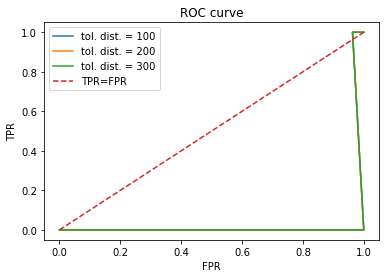

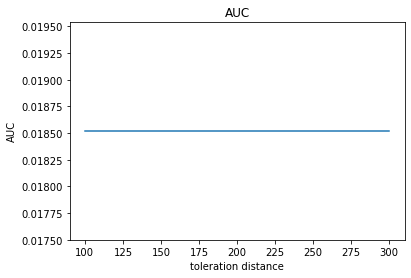

mode: FD
[1.3357412295134097e-06, 0.0007849293563579329, 0.01785714285714285]


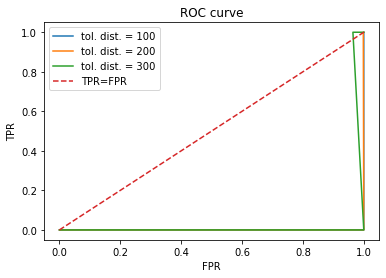

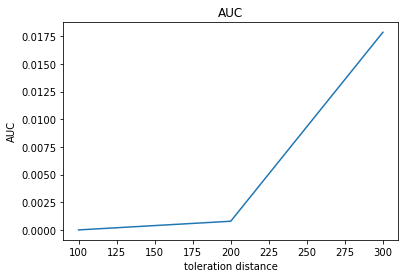

mode: both
[0.019230769230769218, 0.019230769230769218, 0.019230769230769218]


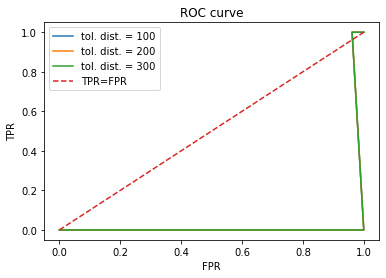

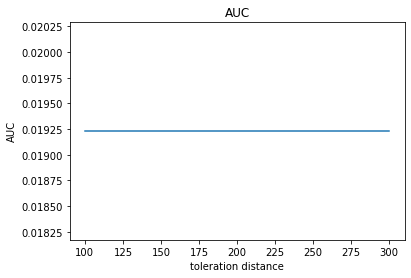

In [17]:
workflow.get_auc(testing_breakpoints)

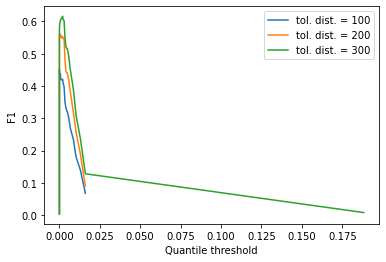

f1 max: [0.4502164502164502, 0.5605306799336651, 0.6159844054580897]


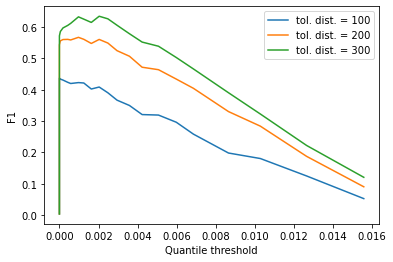

f1 max: [0.43678160919540227, 0.5670103092783505, 0.6342412451361867]


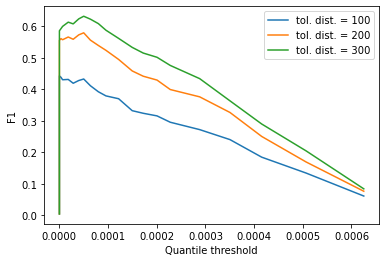

f1 max: [0.4420731707317073, 0.5789473684210527, 0.631578947368421]


In [9]:
reload(utils)
f1s = workflow.get_f1(testing_breakpoints)

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8578990384339343435
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2927833908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3517101457560139070
physical_device_desc: "device: 0, name: Quadro P1000, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [11]:
import tensorflow as tf 
print(tf.__version__)

2.9.1


In [12]:
import tensorflow as tf

print(tf.test.is_gpu_available())
# assert tf.test.is_built_with_cuda()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
